# detecting repeat regions

In [1]:
import re
import pylab as plt
import numpy as np
import pandas as pd
from importlib import reload
from Bio.Seq import Seq
from Bio import SeqIO
from snipgenie import app, tools, rdiff

In [2]:
rec = SeqIO.read(app.mbovis_gb, format='gb')

In [3]:
df=tools.genbank_to_dataframe(app.mbovis_gb, cds=True)
df['gene']=df.gene.fillna('')

In [4]:
g=df#[df.locus_tag.fillna('').str.contains('MB0097c')]
g=g[(g.gene.str.contains('PE_PGRS|PPE')) | (g.feat_type=='repeat_region')]
len(g)

136

In [9]:
seq = g.iloc[0].sequence

In [10]:
def get_repeats(seq):
    repeat_regions = []
    for match in re.finditer(r"(.{5,}?)\1+", seq):
        repeat_regions.append(match.group())
    return repeat_regions
    
get_repeats(seq)

['CTGGCCTGGC', 'GCTGCCGCTGCC', 'CCTGCTCCTGCT', 'TGGCTGTGGCTG', 'GCACAGCACA']

In [26]:
def find_repeats_with_coordinates(genome_sequence,min_size=1):
    repeat_regions = []
    for match in re.finditer(r"(.{5,}?)\1+", genome_sequence):
        repeat_region = match.group()
        repeat_start = match.start()
        repeat_end = match.end()
        repeat_regions.append((repeat_region, repeat_start, repeat_end))
    return repeat_regions

find_repeats_with_coordinates(seq,5)

[('CTGGCCTGGC', 207, 217),
 ('GCTGCCGCTGCC', 267, 279),
 ('CCTGCTCCTGCT', 731, 743),
 ('TGGCTGTGGCTG', 874, 886),
 ('GCACAGCACA', 1328, 1338)]

## look at read coverage in the regions

In [151]:
def groupby_interval(df, clip=2, interval=100):
    """Group over an interval - used for samtools depth data"""
    
    min = df.pos.min()
    max=df.pos.max()
    b = np.arange(min, max, interval)
    #rint (b)
    x=df.groupby(pd.cut(df.pos, bins=b, labels=b[:-1], right=False)).mean(numeric_only=True)['depth']
    x = x.clip(0,clip)
    x = x.replace(0,np.nan)
    return x.dropna()

In [12]:
samples = pd.read_csv('/storage/btbgenie/test_results/samples.csv',index_col=0)
bam = samples.iloc[2].bam_file
name = samples.iloc[1]['sample']

In [ ]:
reload(tools)
def get_gene_depths(bam_file):
    found=[]
    res={}
    i=0
    for idx,r in g.iterrows():   
        d=tools.samtools_depth(bam_file,None,r.start,r.end,mapq=10)
        d1=tools.samtools_depth(bam_file,None,r.start,r.end,mapq=0)
        ratio = d.depth.sum()/d1.depth.sum()    
        #print (d1.depth.sum(),d.depth.sum(),ratio )
        name=r.gene        
        if ratio < .95:
            found.append(r['locus_tag'])        
            res[name]=d,d1
        seq = r.sequence
        
    found = df[df.locus_tag.isin(found)]
    return res

res=get_gene_depths(bam)

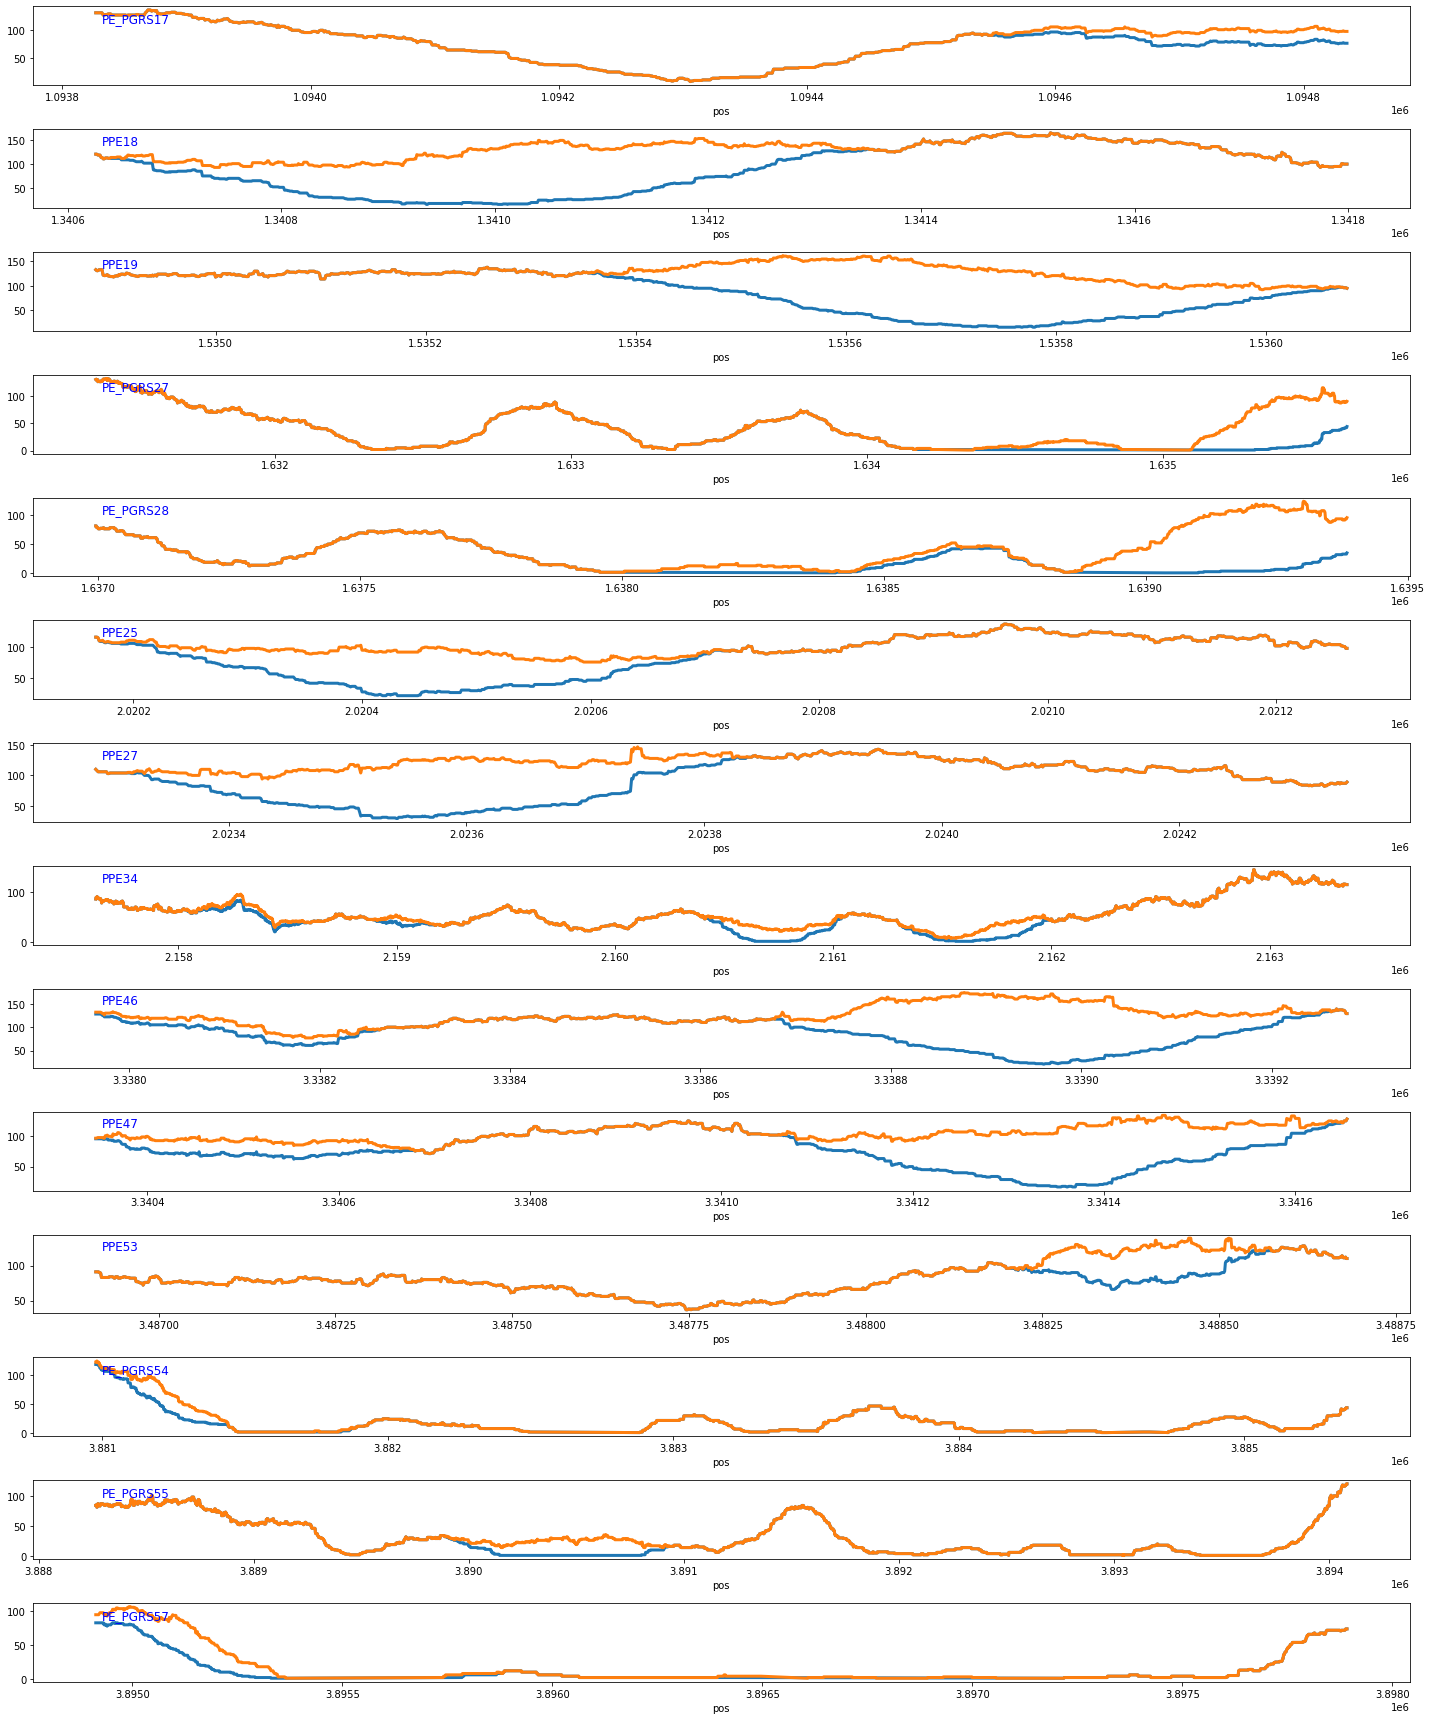

In [28]:
fig,ax=plt.subplots(len(res),1,figsize=(20,24))
axs=ax.flat
i=0
for n in res:
    d,d1=res[n]    
    ax=axs[i]
    d.plot(x='pos',y='depth',lw=3,ax=ax,legend=False)
    d1.plot(x='pos',y='depth',lw=3,ax=ax,legend=False)  
    ax.text(.05,.8,n,color='blue',transform=ax.transAxes,fontsize=12)
    i+=1
plt.tight_layout()

In [33]:
seq = g[g.gene=='PPE53'].iloc[0].translation
print (seq,len(seq))
print (find_repeats_with_coordinates(seq,5) )

MNYSVLPPEINSLRMFTGAGSAPMLAASVAWDRLAAELAVAASSFGSVTSGLAGQSWQGAAAAMAAAAAPYAGWLAAAAARAAGASAQAKAVASAFEAARAATVHPMLVAANRNAFVQLVLSNLFGQNAPAIAAAEAMYEQMWAADVAAMVGYHGGASAAAAQLSSWSIGLQQALPAAPSALAAAIGLGNIGVGNLGGGNTGEYNLGSGNSGNANVGSGNSGNANVGSGNDGATNLGSGNIGNTNLGSGNVGNVNLGSGNRGFGNLGNGNFGSGNLGSGNTGSTNFGGGNLGSFNLGSGNIGSSNIGFGNNGDNNLGLGNNGNNNIGFGLTGDNLVGIGALNSGIGNLGFGNSGNNNIGFFNSGNNNVGFFNSGNNNFGFGNAGDINTGFGNAGDTNTGFGNAGFFNMGIGNAGNEDMGVGNGGSFNVGVGNAGNQSVGFGNAGTLNVGFANAGSINTGFANSGSINTGGFDSGDRNTGFGSSVDQSVSSSGFGNTGMNSSGFFNTGNVSAGYGNNGDVQSGINNTNSGGFNVGFYNSGAGTVGIANSGLQTTGIANSGTLNTGVANTGDHSSGGFNQGSDQSGFFGQP 589
[('GSGNSGNANVGSGNSGNANV', 206, 226)]


In [24]:
for i,r in samples[:4].iterrows():
    res=get_gene_depths(r.bam_file)
    print (i,res.keys())

TB19-001638 dict_keys(['PE_PGRS4', 'PE_PGRS17', 'PPE18', 'PPE19', 'PE_PGRS27', 'PE_PGRS28', 'PPE24', 'PPE25', 'PPE27', 'PPE34', 'PPE71', 'PE_PGRS45', 'PPE46', 'PPE47', 'PPE53', 'PPE70', 'PE_PGRS54', 'PE_PGRS55', 'PE_PGRS57'])
TB19-002561 dict_keys(['PE_PGRS17', 'PPE18', 'PPE19', 'PE_PGRS27', 'PE_PGRS28', 'PPE24', 'PPE25', 'PPE27', 'PPE34', 'PPE71', 'PE_PGRS45', 'PPE46', 'PPE47', 'PPE53', 'PE_PGRS54', 'PE_PGRS55', 'PE_PGRS57'])
TB19-006435 dict_keys(['PE_PGRS17', 'PPE18', 'PPE19', 'PE_PGRS27', 'PE_PGRS28', 'PPE25', 'PPE27', 'PPE34', 'PPE46', 'PPE47', 'PPE53', 'PE_PGRS54', 'PE_PGRS55', 'PE_PGRS57'])
TB19-006791 dict_keys(['PE_PGRS17', 'PPE18', 'PPE19', 'PE_PGRS27', 'PE_PGRS28', 'PPE25', 'PPE27', 'PPE34', 'PPE46', 'PPE47', 'PE_PGRS54', 'PE_PGRS55', 'PE_PGRS57'])


## test calling with/without masking - which sites are wrong?